## Import Packages

In [19]:
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential
import keras
from keras.layers import Activation, Dropout, Flatten, Dense,Conv2D,Conv3D,MaxPooling2D,AveragePooling2D,BatchNormalization
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score
import seaborn as sns
import tensorflow as tf
import matplotlib.image as mpimg
print(os.listdir("../input"))
print(os.listdir("../input/weights/"))
IMAGE_SIZE = 32

['aerial-cactus-identification', 'weights']
['vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']


## Set Directories

In [20]:
train_dir = "../input/aerial-cactus-identification/train/train/"
test_dir = "../input/aerial-cactus-identification/test/test/"
train_df = pd.read_csv('../input/aerial-cactus-identification/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


## Check out an image sample

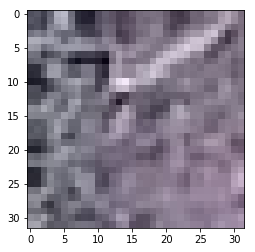

In [21]:
im = cv2.imread("../input/aerial-cactus-identification/train/train/01e30c0ba6e91343a12d2126fcafc0dd.jpg")
plt.imshow(im)

## Read and convert horizontally an vertically augmented images to numpy array

In [22]:
X_tr = []
Y_tr = []
imges = train_df['id'].values
for img_id in tqdm_notebook(imges):
    image = np.array(cv2.imread(train_dir + img_id))
    X_tr.append(image)
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  

    X_tr.append(np.flip(image))
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  

    X_tr.append(np.flipud(image))
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  

    X_tr.append(np.fliplr(image))
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  
                
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)




# Save an instance of initial images for future use

In [23]:

X_tr_2 = X_tr
Y_tr_2 = Y_tr


In [24]:

X_tr = X_tr_2
Y_tr = Y_tr_2


In [25]:
X_tr.shape,Y_tr.shape

((70000, 32, 32, 3), (70000,))

# Read test images

In [26]:
test_image_names = []
for filename in os.listdir(test_dir):
    test_image_names.append(filename)
test_image_names.sort()
X_ts = []
#imges = test_df['id'].values
for img_id in tqdm_notebook(test_image_names):
    X_ts.append(cv2.imread(test_dir + img_id))    
X_ts = np.asarray(X_ts)
X_ts = X_ts.astype('float32')
X_ts /= 255

In [27]:
x_train,x_test,y_train,y_test = train_test_split(X_tr, Y_tr, test_size = 0.2 , stratify = Y_tr )

# Load weights of pretrained VGG16 model

In [28]:


base=keras.applications.vgg16.VGG16(include_top=False, weights='../input/weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',input_shape=(32,32,3))



# Train

In [29]:


print("Current train size:",X_tr.shape)
model = Sequential()
model.add(base)

model.add(Flatten())
model.add(Dense(256, use_bias=True))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
callback=[keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='auto', restore_best_weights=True),
         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto')]
model.fit(X_tr,Y_tr,batch_size=64, epochs=80, verbose=1,   validation_split=0.1,callbacks=callback)


Current train size: (70000, 32, 32, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2

# Results

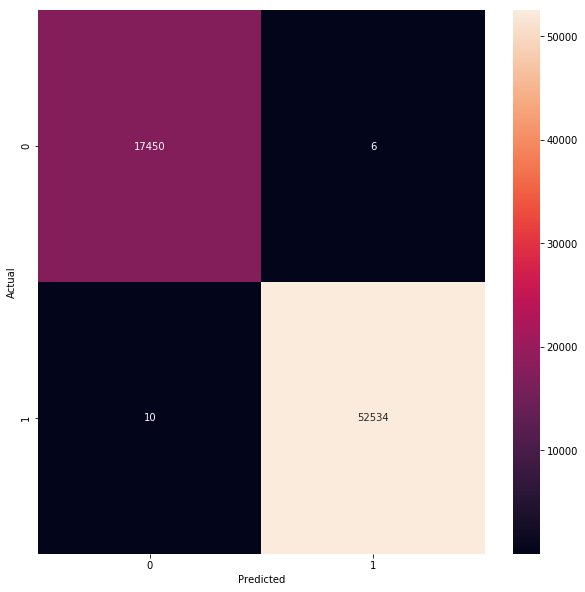

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17456
           1       1.00      1.00      1.00     52544

   micro avg       1.00      1.00      1.00     70000
   macro avg       1.00      1.00      1.00     70000
weighted avg       1.00      1.00      1.00     70000



 AUC: 1.0000


In [30]:



clf=model
y_pred_proba = clf.predict_proba(X_tr_2)

y_pred = clf.predict_classes(X_tr_2)
conf_mat = confusion_matrix(Y_tr_2, y_pred)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['0','1'], yticklabels=['0','1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(Y_tr_2, y_pred, target_names=['0','1']))
print("\n\n AUC: {:<0.4f}".format(roc_auc_score(Y_tr_2,y_pred_proba)))



# Submit

In [31]:



test_df = pd.read_csv('../input/aerial-cactus-identification/sample_submission.csv')
X_test = []
imges = test_df['id'].values
for img_id in tqdm_notebook(imges):
    X_test.append(cv2.imread(test_dir + img_id))     
X_test = np.asarray(X_test)
X_test = X_test.astype('float32')
X_test /= 255

y_test_pred  = model.predict_proba(X_test)

test_df['has_cactus'] = y_test_pred
test_df.to_csv('tf_learning_vgg16_aug2_80epoch.csv', index=False)